In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import important libraries

In [2]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import os
import matplotlib.pyplot as plt
import dill
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load data

In [ ]:
data = pd.read_parquet("/content/drive/MyDrive/Query-Search-LLM-Model/insights")

In [ ]:
data.shape

(58505, 4)

In [ ]:
data.head(3)

,links,Queries,images,insights
0,https://www.flannels.com/ami-paris-ami-de-coeu...,Ami De Coeur Wool Jumper in blue looking for s...,/content/drive/MyDrive/Query-Search-LLM-Model/...,"[0.27834999561309814, 0.6414205431938171, 0.16..."
1,https://www.flannels.com/ami-paris-ami-de-coeu...,I need a high-quality wool jumper for the fall...,/content/drive/MyDrive/Query-Search-LLM-Model/...,"[0.918123185634613, 1.6053258180618286, 0.1306..."
2,https://www.flannels.com/ami-paris-ami-de-coeu...,I want a blue Ami Paris jumper something with ...,/content/drive/MyDrive/Query-Search-LLM-Model/...,"[0.17485029995441437, 0.5286245346069336, 0.57..."


# Split data into train and test

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.05, random_state=42)

# Split train data into train and validation

In [ ]:
train_data.shape, test_data.shape

((55579, 4), (2926, 4))

In [ ]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [ ]:
train_data.to_parquet('/content/drive/MyDrive/Query-Search-LLM-Model/train_data')
test_data.to_parquet('/content/drive/MyDrive/Query-Search-LLM-Model/test_data')

In [4]:
train_data = pd.read_parquet('/content/drive/MyDrive/Query-Search-LLM-Model/train_data')
test_data = pd.read_parquet('/content/drive/MyDrive/Query-Search-LLM-Model/test_data')

In [ ]:
train_data.head(3)

,links,Queries,images,insights
0,https://www.flannels.com/fred-perry-plain-polo...,I need a simple white Fred Perry polo shirt ma...,/content/drive/MyDrive/Query-Search-LLM-Model/...,"[0.10476528853178024, 0.015176202170550823, 0...."
1,https://www.flannels.com/polo-ralph-lauren-tec...,Looking for comfy black joggers with lots of p...,/content/drive/MyDrive/Query-Search-LLM-Model/...,"[1.7424988746643066, 0.48024997115135193, 0.11..."
2,https://www.flannels.com/vivienne-westwood-str...,Need a lightweight jacket for spring preferabl...,/content/drive/MyDrive/Query-Search-LLM-Model/...,"[1.9303619861602783, 1.5666308403015137, 0.003..."


# Create tokenizer
#### The AutoTokenizer from Hugging Face automatically loads the correct tokenizer for a given model. For "sentence-transformers/all-MiniLM-L6-v2", it tokenizes input text into subword units that the MiniLM model can understand, handling tasks like padding, truncating, and adding special tokens.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/Query-Search-LLM-Model/tokenizer')

('/content/drive/MyDrive/Query-Search-LLM-Model/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Query-Search-LLM-Model/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Query-Search-LLM-Model/tokenizer/vocab.txt',
 '/content/drive/MyDrive/Query-Search-LLM-Model/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Query-Search-LLM-Model/tokenizer/tokenizer.json')

In [5]:
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Query-Search-LLM-Model/tokenizer')

In [ ]:
class QueryDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.text_pipline = lambda x: tokenizer.encode(x, padding='max_length', max_length=128, truncation=True)

    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        query = self.data.iloc[index]['Queries']
        query = self.text_pipline(query)

        label = self.data.iloc[index]['insights']
        return query, label

In [ ]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _text, _label in batch:
        label_list.append(_label)
        text_list.append(torch.tensor(_text))
        lengths.append(len(_text))
    label_list = torch.tensor(np.array(label_list), dtype=torch.float)
    lengths = torch.tensor(lengths)
    padded_text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    return padded_text_list, label_list, lengths

In [ ]:
class LSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, rnn_hidden_size, fc_hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
    self.lstm = nn.LSTM(embedding_dim, rnn_hidden_size, batch_first=True, bidirectional=True, num_layers = num_layers)
    self.linear_1 = nn.Linear(rnn_hidden_size*2, fc_hidden_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.linear_2 = nn.Linear(fc_hidden_size, 512)

  def forward(self, text, lengths):
    out = self.embedding(text)
    out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu(), batch_first=True, enforce_sorted=False)
    out, (hidden, cell) = self.lstm(out)
    out = hidden[-2:,:,:]
    out = torch.cat((out[0,:,:], out[1,:,:]), dim=1)
    out = self.linear_1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.linear_2(out)
    return out

In [ ]:
def train(dataloader, model, optimizer, loss_fn, device='cpu'):
    model.train()
    total_loss = 0

    for text, label, lengths in dataloader:
        text, label, lengths = text.to(device), label.to(device), lengths.to(device)

        optimizer.zero_grad()
        pred = model(text, lengths)
        loss = loss_fn(pred, label)
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        optimizer.step()

    return total_loss / len(dataloader)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
    def step(self, train_loss):
        if train_loss < self.best_loss - self.min_delta:
            self.best_loss = train_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            return True
        return False

In [ ]:
train_data_custom = QueryDataset(train_data, tokenizer)
test_data_custom = QueryDataset(test_data, tokenizer)

train_loader = DataLoader(train_data_custom, batch_size=16, shuffle=True, num_workers=16, drop_last=False, collate_fn=collate_batch)
test_loader = DataLoader(test_data_custom, batch_size=16, shuffle=True, num_workers=16, drop_last=False, collate_fn=collate_batch)

vocab_size = tokenizer.vocab_size
embedding_dim = 64
rnn_hidden_size = 128
fc_hidden_size = 128
num_layers = 2
model = LSTM(vocab_size, embedding_dim, rnn_hidden_size, fc_hidden_size, num_layers)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
num_epochs = 100
train_loss_hist = [0] * num_epochs
val_loss_hist = [0] * num_epochs
for epoch in range(num_epochs):
    model.train()
    train_loss = train(train_loader, model, optimizer, loss_fn, device)
    train_loss_hist[epoch] = train_loss

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

    if early_stopping.step(train_loss_hist[epoch]):
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/100, Train Loss: 0.3785
Epoch 2/100, Train Loss: 0.3727
Epoch 3/100, Train Loss: 0.3722
Epoch 4/100, Train Loss: 0.3719
Epoch 5/100, Train Loss: 0.3715
Epoch 6/100, Train Loss: 0.3713
Epoch 7/100, Train Loss: 0.3710
Epoch 8/100, Train Loss: 0.3708
Epoch 9/100, Train Loss: 0.3704
Epoch 10/100, Train Loss: 0.3697
Epoch 11/100, Train Loss: 0.3687
Epoch 12/100, Train Loss: 0.3672
Epoch 13/100, Train Loss: 0.3651
Epoch 14/100, Train Loss: 0.3625
Epoch 15/100, Train Loss: 0.3594
Epoch 16/100, Train Loss: 0.3561
Epoch 17/100, Train Loss: 0.3523
Epoch 18/100, Train Loss: 0.3479
Epoch 19/100, Train Loss: 0.3421
Epoch 20/100, Train Loss: 0.3359
Epoch 21/100, Train Loss: 0.3307
Epoch 22/100, Train Loss: 0.3255
Epoch 23/100, Train Loss: 0.3222
Epoch 24/100, Train Loss: 0.3186
Epoch 25/100, Train Loss: 0.3157
Epoch 26/100, Train Loss: 0.3132
Epoch 27/100, Train Loss: 0.3110
Epoch 28/100, Train Loss: 0.3090
Epoch 29/100, Train Loss: 0.3073
Epoch 30/100, Train Loss: 0.3056
Epoch 31/100, Train

In [ ]:
with open('/content/drive/MyDrive/Query-Search-LLM-Model/lstm_model_100.pkl', 'wb') as f:
    dill.dump(model, f)

In [6]:
model = dill.load(open('/content/drive/MyDrive/Query-Search-LLM-Model/lstm_model_100.pkl', 'rb'))

In [31]:
class TestModel(nn.Module):
    def __init__(self, model, store, tokenizer, device):
        super(TestModel, self).__init__()
        self.model = model.to(device)
        self.store = store
        self.text_pipline = lambda x: tokenizer.encode(x, padding='max_length', max_length=128, truncation=True)
        self.device = device

    def forward(self, test):
        query = test['Queries'].iloc[0]
        query_tokens = self.text_pipline(query)
        query_tensor = torch.tensor(query_tokens, device=self.device).unsqueeze(0)
        length = torch.tensor([len(query_tokens)], device=self.device)
        out = self.model(query_tensor, length)
        return out

    def similarities(self, test, metric='mse'):
        similarities = []
        out = self.forward(test)
        out = out.squeeze(0)

        for i in range(len(self.store)):
            insight = torch.tensor(self.store['insights'].iloc[i], device=self.device)

            if metric == 'cosine':
                distance = 1 - torch.nn.functional.cosine_similarity(out, insight, dim=0)
            elif metric == 'mse':
                distance = torch.nn.functional.mse_loss(out, insight)
            else:
                raise ValueError(f"Unsupported similarity metric: {metric}")
            similarities.append(distance.item())
        return similarities

    def visualization(self, test):
        similarities = self.similarities(test)
        highest_10_indices = np.argsort(similarities)[-10:][::-1]

        images = self.store.iloc[highest_10_indices]['images'].tolist()
        similarity_scores = [similarities[i] for i in highest_10_indices]

        num_images = len(images)
        num_rows = (num_images // 5) + (1 if num_images % 5 != 0 else 0)

        plt.figure(figsize=(15, num_rows * 5))

        for i, (image_path, score) in enumerate(zip(images, similarity_scores)):
            plt.subplot(num_rows, 5, i + 1)
            img = Image.open(image_path)
            img = plt.imread(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Sim: {score:.4f}", fontsize=12)

        plt.suptitle(f"Query: {test['Queries'].iloc[0]}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
testing = TestModel(model, train_data, tokenizer, device)

In [33]:
def custom_query(user_input):
  query = pd.DataFrame({'Queries': [user_input]})
  testing.visualization(query)

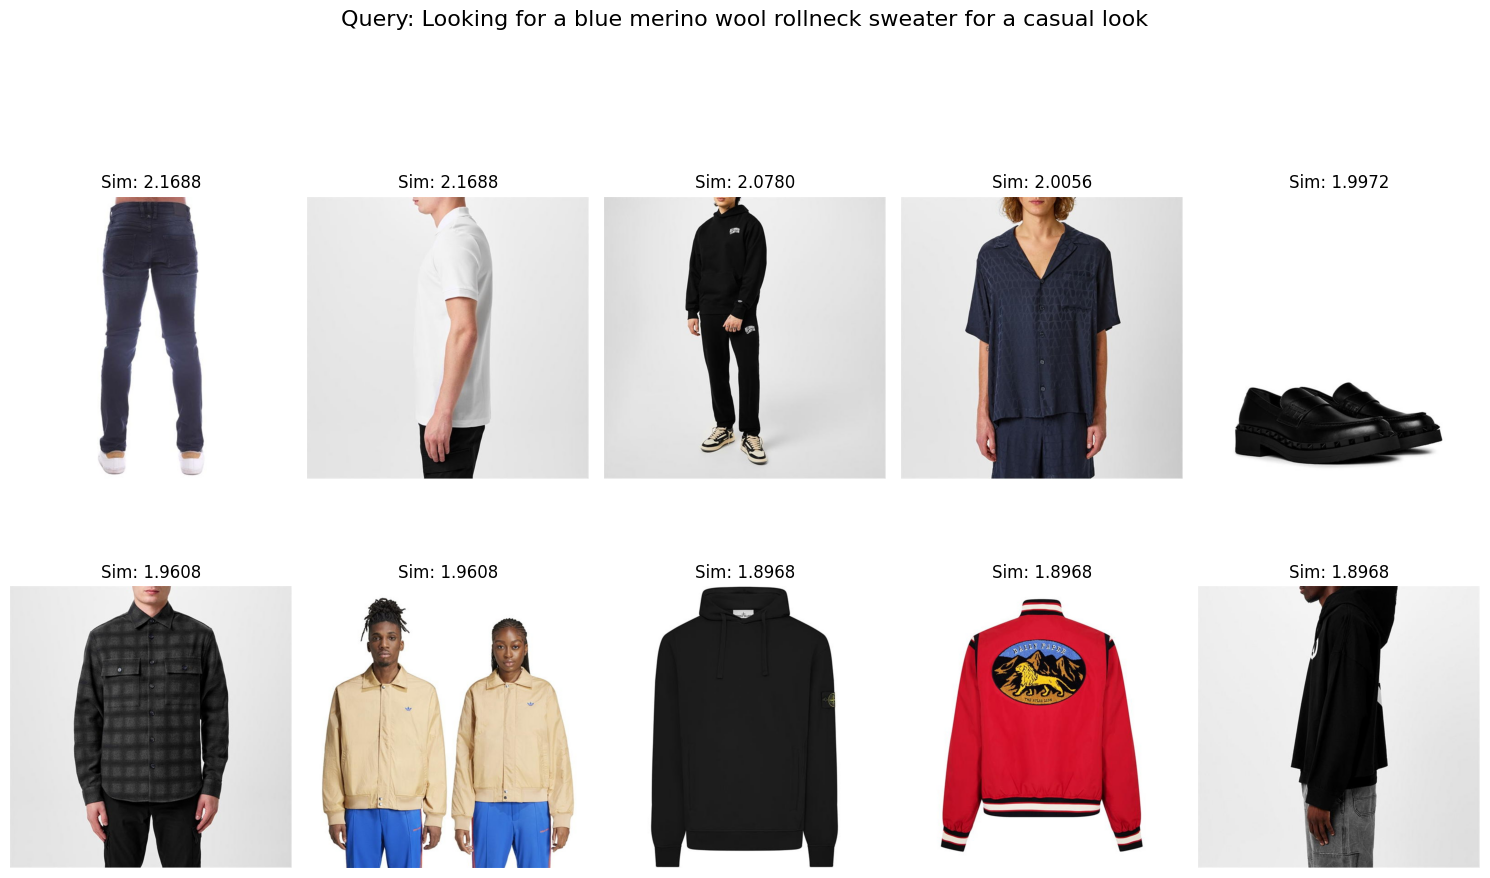

In [34]:
custom_query(train_data.iloc[987].Queries)

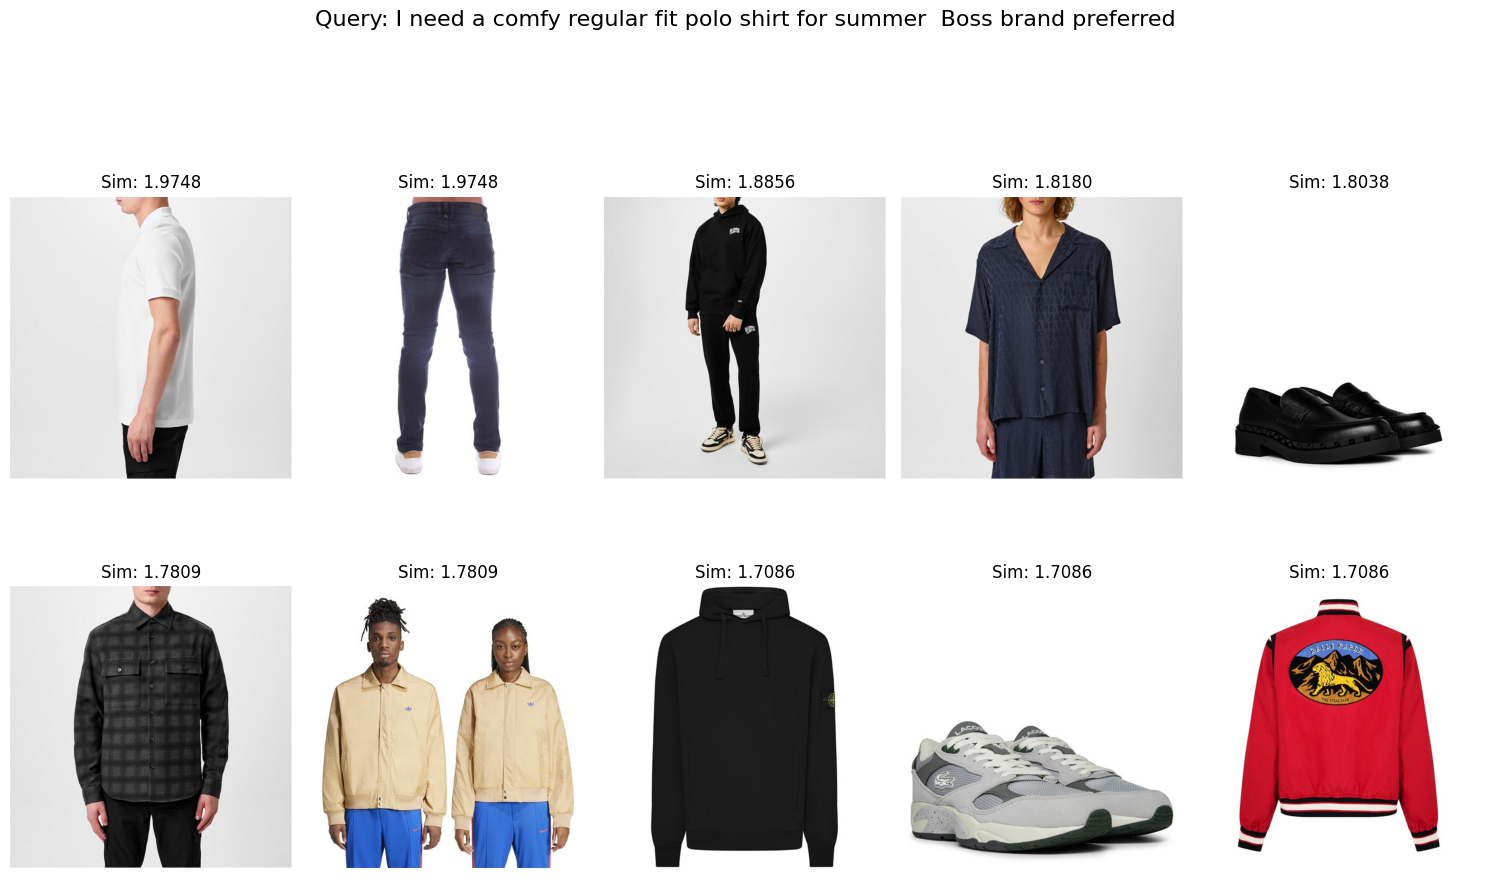

In [35]:
custom_query(train_data.iloc[7773].Queries)